# Free energy landscapes and clustering with Gaussian mixture models
This tutorial shows how to perform density and free energy estimation with Gaussian mixture models (GMM) and model selection. Note that while the tutorial shows an example of a 2D dataset, the estimation is implemented to accommodate datasets of any dimensionality. The visualization part, however, only supports 1D and 2D.

## 1. Theory
### 1.2 Gaussian mixture models
A Gaussian mixture density is a weighted sum of Gaussian components, 
$$\rho(x) = \sum\limits_{i=1}^{N_{\text{basis}}} \pi_i \mathcal{N}(x|\; \mu_i,\; \Sigma_i),$$
where $\pi_i$ is the amplitude, $\mu_i$ is the mean and $\Sigma_i$ is the covariance of the $i$th Gaussian. The amplitudes, means and covariances are here optimized iteratively with Expectation-Maximization. The expectation-maximization algorithm consists of two steps, abbreviated E-step and the M-step.

#### 1.2.1 E-step
In the E-step, the responsibility of each data point with respect to the Gaussian components is calculated as
$$ \gamma_{ni} = \frac{\pi_i \mathcal{N}(x_n|\; \mu_i,\; \Sigma_i)}{\sum\limits_{i=1}^{N_{\text{basis}}} \pi_i \mathcal{N}(x_n|\; \mu_i,\; \Sigma_i)}.$$

#### 1.2.2 M-step
The parameters are then updated in the maximization step. The amplitudes are updated with
$$\pi_i = \frac{\sum_n \gamma_{ni}}{\sum_{n,i}\gamma_{ni}},$$
the means with
$$\mu_i = \frac{\sum_n \gamma_{ni}x_n}{\sum_n \gamma_{ni}},$$
and covariances with
$$\Sigma_i = \frac{\sum_n \gamma_{ni}(x_n-\mu_i)(x_n-\mu_i)^T}{\sum_n \gamma_{ni}} .$$

These two steps are carried out until convergence of the log-likelihood, $\mathcal{l} = \frac{1}{N}\sum_{n=1}^N \log (\rho(x_n))$. 

### 1.3 Model selection 
To select the number of Gaussian components in the density model, we can use either $K$-fold cross-validation or Bayesian information criterion for identifying one model, or Akaike information criterion for weighting multiple models. 

#### 1.3.1 $K$-fold cross-validation
In $K$-fold cross-validation, the data is split into $K$ folds. One chunk of the data is used for training model parameters, while the other is used for validating the trained model. In this case, model validation occurs by calculating the log-likelihood of the validation set. In $K$-fold cross-validation, each fold is used as a validation set once per model. This results in $K$ training and validation sets for each model. The total validation log-likelihood score of a model is the summed validation log-likelihoods of all validation sets. 

#### 1.3.2 Bayesian information criterion
The second option is to perform model selection with Bayesian information criterion (BIC). In short, the log-likelihood of the fitted data will increase with increased number of parameters. The BIC tries to account for this by adding a penalty for the number of parameters,
$$
BIC = \log(N) N_{param} - 2\mathcal{l},
$$
where $\mathcal{l}$ is the log-likelihood of the data.

#### 1.3.3 Weighting multiple GMMs (stacking landscapes)
The final density model can also be a weighted average of all estimated models based on the Akaike information criterion. The Bayesian information criterion (BIC) is good for selecting one model (it does so with probability one). However, for weighting models, the Aikake information criterion (AIC) is better suited. AIC follows the same idea as BIC such that complex models are penalized. However, the AIC has a slightly different formula which makes it better suited for weighting models,
$$
AIC = 2N_{param}-2\mathcal{l},
$$
where $\mathcal{l}$ is the log-likelihood of the data. The weight of model $m$ with an AIC score of $a_m$ is then set to
$$
w_m = \frac{e^{-\frac{\Delta a_m}{2}}}{\sum \limits_{m=1}^{N_{models}} e^{-\frac{\Delta a_m}{2}}},
$$
where $\Delta a_m = a_m - min\big(\{a_{m'}\}_{m'=1}^{N_{models}}\big)$.

### 1.4 Clustering density maxima
Using the estimated Gaussian mixture density, we can identify core states at density maxima and divide the points into clusters. This is done by first computing the Hessian at each point and determine whether it belongs to a density maximum or not. Each point that belongs to a density maximum is then connected to other points which are part of the same maximum. This creates so called connected components. Once the connected components are constructed, cluster labels can be assigned so that all points within the same connected component have the same cluster label. Transition points (points that do not belong to a density maximum), are not assigned to clusters when identifying core states. However, they can be assigned a cluster label. This is done by sorting the transition points in descending density order and one-by-one assigning them to the same cluster as the closest point with a cluster label.

## 2. Reading the data
The data should be on the form [n_samples x n_dimensions]. Each row contains one data sample projected onto a CV of *n_dimensions* dimensions. In this case, the dataset is from a REST simulation of calmodulin, and the CV is the projection of samples onto PCA components.

In [1]:
import numpy as np
import GMM_FE

data = np.loadtxt('data/CaM_PCA_CA_contacts_REST.txt')

## 3. Constructing the object and setting parameters
Create a free energy and clustering object. In principle, *data*, minimum number of components, *min_n_components*, and maximum number of components, *max_n_components* need to be specified. If *max_n_components* is not specified, the free energy estimation and clustering will be done using *min_n_components* components. 

The settings of the necessary parameters will be printed below the cell. If not supplied by the user when creating the object, the default values will be used. 

**The following parameters are use to pick a method for model selection:**
1. *n_splits*: The number of folds used in cross-validation, $K$. If *n_splits = 1*, model selection will be done with Bayesian information criterion (BIC). <br>
2. *stacking_landscapes*: when set to True, the final density model will be a weighted average of all estimated models, regardless of the value on *n_splits*.
<br>

**Other parameters are:**
1. *shuffle_data*: Whether or not to shuffle the data when performing cross-validation model selection.
2. *n_iterations*: The number of times to reestimate the same model, starting from different random initializations. The model with largest log-likelihood is picked as final estimated model.
3. *temperature*: Temperature used in the simulation [K].
4. *n_grids*: The number of grid cells used along all dimensions when plotting the free energy landscape. Example: for a 2D dataset with n_grids=50, the estimated free energy will be evaluated and visualized on a [50 x 50] grid. Note that the does not affect the density and free energy estimation, just visualization.
5. *convergence_tol*: The convergence tolerance (change in log-likelihood during training).
6. *x_lims*: Limits on the grid used for visualization. If not supplied, it will default to min/max values.
7. *n_component_step*: Example: if set to 3, and *min_n_components=8* and *max_n_components=15*, models with *n_components={8, 11, 14}* will be evaluated.
8. *verbose*: Whether or not to print details and estimation progression.

In [2]:
gmm_FE = GMM_FE.FreeEnergy(data, min_n_components=8, max_n_components=20, temperature=300.0, 
                            n_iterations=3, n_grids=50, n_splits=4,stack_landscapes=False)

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 4
   shuffle_data = False
   n_iterations = 3
   n_grids = 50
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[-4.8644411168558515, 10.83157794323054], [-6.875103988258936, 8.627237475799573]]
   temperature = 300.0
   min_n_components = 8
   max_n_components = 20
   n_components_step = 1
*----------------------------------------------------------------------------*


## 4. Estimating free energy landscapes
> **coords, FE_landscape, FE_points = gmm_FE.landscape()**

will estimate the density and free energy landscape with Gaussian mixture models. The axes limits of the landscape are printed above. 
<br><br>
**This returns:**
1. *coords*: The coordinates of the grid that is used for visualization.
2. *FE_landscape*: The estimated free energy of each grid point.
3. *FE_points*: The estimated free energy of each point in *data*.

It is also possible to estimate standard error by writing 
> **standard_error_FE = gmm_FE.standard_error()**

This returns the standard error of the free energy landscape, evaluated on each grid point.<br>
Note: When estimating the standard error for a 1D landscape, the standard error will be shown in the visualization.

In [3]:
coords, FE_landscape, FE_points = gmm_FE.landscape()

Estimating density with GMM.
# Components = 8
# Components = 9
# Components = 10
# Components = 11
# Components = 12
# Components = 13
# Components = 14
# Components = 15
# Components = 16
# Components = 17
# Components = 18
# Components = 19
# Components = 20
Training final model with 14 components.
Evaluating density in landscape
Density grid shape: (50, 50)


## 5. Visualizing the free energy landscape
If the dataset is 1D or 2D, the free energy can be visualized. To visualize the estimated free energy landscape, we call the *visualize* function. To visualize with the standard parameter settings, it is just to run 
<br>
> **gmm_FE.visualize()**

<br> However, you might want to change some of the parameters. 
<br><br>
**The following parameters can be changed:**
1. *title*: The title of the figure
2. *fontsize*: Title fontsize, other labels are changed according to this
3. *savefig*: True/False (whether to save a .png and .eps figure)
4. *xlabel*: The x-label
5. *ylabel*: The y-label (in case of a 2D dataset)
6. *vmax*: Colormap max cutoff value.
7. *n_contour_levels*: Determines the number and positions of the contour lines / regions in contourf.
8. *show_data*: True/False (whether to scatter-plot the original data and/or clustering)

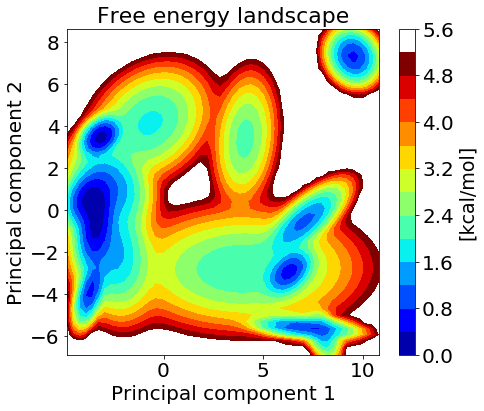

In [4]:
gmm_FE.visualize(savefig=False, vmax=5, xlabel='Principal component 1', ylabel='Principal component 2')

## 6. Cluster points at free energy minima
Using the estimated Gaussian mixture density, we can identify core states at density maxima and divide the points into clusters. Clustering the free energy landscape can be done with 
<br> 
> **labels, cluster_centers = gmm_FE.cluster(data, FE_points)**

<br>Recall that *FE_points* is an array with the estimated free energy of each point in *data*. To make the clustering slightly more robust, we can do it over the grid that we use for visualization and then return cluster indices of the *data* points,
> **labels, cluster_centers = gmm_FE.cluster(grid_points, FE_points, data)**

The grid coordinates are kept in *coords*. We also need to parse *data* as a third argument to return the cluster labels and cluster center indices of the *data* points. By default, we will get the core state clustering (core state points have cluster indices > 0, and transition points have cluster indices equal to zero). To assign cluster indices to the non-core state points (transition points), just set *assign_transition_points* to True.
<br> <br>
**This returns:**
1. *labels*: The cluster label/index of each point, denoting which cluster the point belongs to. If zero, the point is a transition point, otherwise it belongs to some intermediate state.
2. *cluster_centers*: Contains the indices corresponding to the point of each cluster that has the smallest free energy. In *return_center_coords* is set to True, this contains the coordinates of the cluster centers instead.
<br>

When the clustering has already been performed, new points can be assigned cluster labels based on the precomputed clustering (assigning points to the nearest neighbor clusters) with
> **labels = gmm_FE.evaluate_clustering(new_points, assign_transition_points=False)**

In [5]:
labels, cluster_centers = gmm_FE.cluster(coords,FE_points,data, assign_transition_points=False)

Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 1482.0
Clustering data points.
Cluster labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
Done clustering.


## 7. Visualizing the free energy landscape with identified clusters

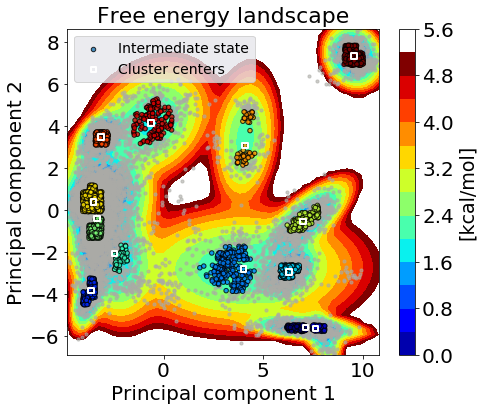

In [6]:
# Visualize free energy landscape with cluster labels
gmm_FE.visualize(savefig=True,vmax=5,show_data=True, xlabel='Principal component 1', ylabel='Principal component 2')